In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from copy import deepcopy
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
from os.path import join as oj
import sys
import acd
from tqdm import tqdm
import pickle as pkl
import torchvision
import models
import time
from functools import partial
sys.path.append('..')
sys.path.append('../..')
# plt.style.use('dark_background')
from visualize import *
import visualize as viz
from transforms_torch import bandpass_filter
from numpy.fft import *
from data import *
from style import *
data_path = './cosmo'
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from acd_wooseok.acd.scores import cd

# load dataset and model

In [7]:
# params
img_size = 256
class_num = 1

In [8]:
# cosmo dataset
transformer = transforms.Compose([ToTensor()])
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  
                              oj(data_path, 'z1_256'),
                              transform=transformer)

# dataloader
data_loader = torch.utils.data.DataLoader(mnu_dataset, batch_size=64, shuffle=False, num_workers=4)

# load model
model = models.load_model(model_name='resnet18', device=device, data_path=data_path).to(device)

Set up

In [9]:
# import modules
from funcs import *
from matfac import *
torch.manual_seed(10)
X = iter(data_loader).next()['image'][0:1].to(device)
X.requires_grad_(True)
baseline = torch.zeros_like(X)

In [10]:
def viz_plot(im, attr):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,7))
    img_viz = ax[0].imshow(im.squeeze().cpu().data)
    interp_viz = ax[1].imshow(attr.squeeze().cpu().data, cmap='RdBu')
    titles = ['original image', 'interpretability score']
    for i, title in enumerate(titles):
        ax[i].set_title(title, fontsize=15)
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].tick_params(left=False, bottom=False)
    plt.subplots_adjust(wspace=0, hspace=0)
    cbar_ax = fig.add_axes([0.94, 0.325, 0.015, 0.3])
    fig.colorbar(interp_viz, cax=cbar_ax)
    plt.show()

# CD score

In [52]:
import itertools
from acd_wooseok.acd.scores import cd

In [53]:
# relevant scores
img_size = 256
superpixel_size = 2 # superpixel size
h_num, w_num = int(img_size/superpixel_size), int(img_size/superpixel_size)

rel_scores = torch.zeros(1, 1, img_size, img_size)

accuracy = []

# output
with torch.no_grad():
    output = model(X).flatten()[1]

In [54]:
with torch.no_grad():
    for h, w in itertools.product(range(h_num), range(w_num)):
        # set up blobs
        blob = torch.zeros(X.size())
        blob[0,0,h*superpixel_size:(h+1)*superpixel_size,w*superpixel_size:(w+1)*superpixel_size] = 1
        
        cd_score = cd.cd(X, model, mask=blob, model_type='resnet18', device='cuda')
        relevant = cd_score[0].flatten()[1]
        irrelevant = cd_score[1].flatten()[1]
        
        accuracy.append(torch.norm(relevant + irrelevant - output))
        if accuracy[-1] > 1e-3:
            print('sum of cd scores do not match the original ouput at (height,width) =', (h,w))
        if torch.isnan(accuracy[-1]).sum().item() >= 1:
            print('Nan occured')

        rel_scores[0,0,h*superpixel_size:(h+1)*superpixel_size, 
                        w*superpixel_size:(w+1)*superpixel_size] = relevant

        print('\r iterations (height,width) =', (h,w), end='')

 iterations (height,width) = (127, 127)

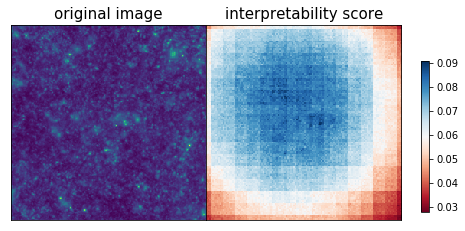

In [55]:
# ver1
viz_plot(X, rel_scores)

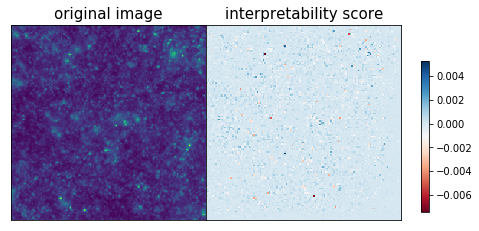

In [51]:
# ver2
viz_plot(X, rel_scores)

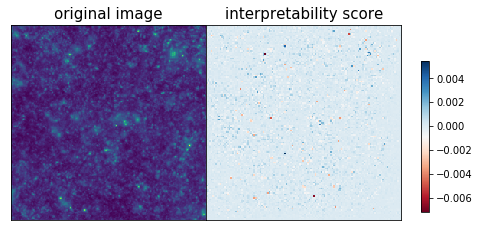

In [47]:
# ver3
viz_plot(X, rel_scores)

### input x * gradient

In [27]:
from captum.attr import InputXGradient
input_x_gradient = InputXGradient(model)
attribution = input_x_gradient.attribute(X, target=1)

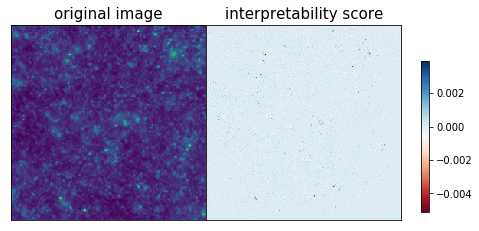

In [28]:
viz_plot(X, attribution)

### gradient shap

In [33]:
from captum.attr import GradientShap
gradient_shap = GradientShap(model)
attribution = gradient_shap.attribute(X, baselines=baseline, target=1)

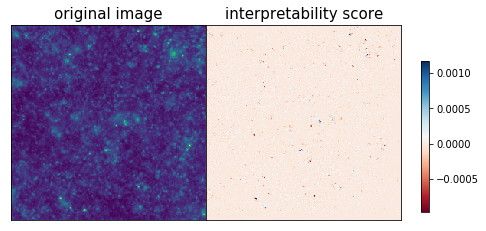

In [34]:
viz_plot(X, attribution)

### integrated gradient

In [35]:
from captum.attr import IntegratedGradients
ig = IntegratedGradients(model)
attribution = ig.attribute(X, target=1)

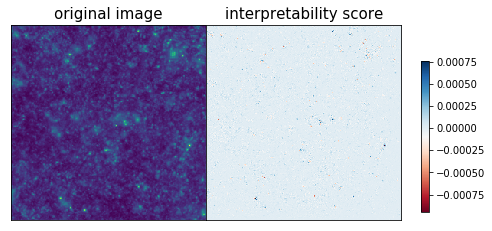

In [36]:
viz_plot(X, attribution)

### saliency

In [13]:
from captum.attr import Saliency
saliency = Saliency(model)
attribution = saliency.attribute(X, target=1, abs=False)

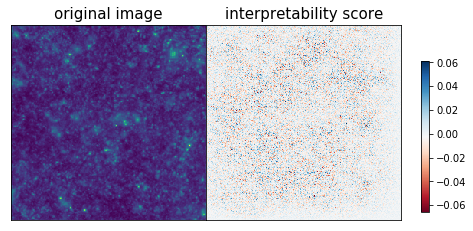

In [14]:
viz_plot(X, attribution)